## Skeletonize approach for feature extraction
 In this section a morphological approach is used to extract features of
 objects
## Imports:


In [1]:
import numpy as np
import os
import skimage.io
import skimage.morphology as morph
import matplotlib.pyplot as plt


## FUNC DEF


In [2]:

def mirrored_periodisation(idx,N):
    ''' mirrored periodisation of signal of length N evaluated at index current_idx
        For a signal s={...0,0,|0|,1,2,3,0,0,...} the result is
        s_p={...2,1,|0|,1,2,3,2,1,0,1,...}
        \param N        support of signal, in example above N=4
        \param idx      index where to evaluate periodic version s_p ot s
    '''
    if idx<0:
        idx=-idx
    elif idx>=N:
        #try and write it out if you want to understand...
        #...it is just a mathematical expression for a mirrored periodic sequence of indices
        idx=(int(idx/(N-1))%2)*(N-1-idx%(N-1))+(1-int(idx/(N-1))%2)*(idx%(N-1))

    #recursive correction
    if idx<0 or idx>=N:
        idx=mirrored_periodisation(idx,N);

    #retunr equivalent index in bounds [0;N-1]
    return idx

def get_nbh(img,x,y,w=3,h=3):
    ''' get neighbourhood around x,y pixel with mirrored periodisation, works
        only with odd w,h! no test if odd or even, so be careful!
        \param w,h      width of nbh, height of nbh. Must be odd
        \param x,y      position where nbh is extracted
    '''
    nx,ny=img.shape
    delta_w=int(w/2)
    delta_h=int(h/2)

    nbh=np.zeros((w,h))
    for xx in range(x-delta_w,x+delta_w+1):
        for yy in range(y-delta_h,y+delta_h+1):
            #get equivalent idx in case of values out of bounds
            x_idx=mirrored_periodisation(xx,nx)
            y_idx=mirrored_periodisation(yy,ny)
            #put values in nbh, origin (x,y) in the middle of nbh
            nbh[xx-x+delta_w][yy-y+delta_h]=img[x_idx][y_idx]

    return nbh

def load_img_seq(file_path, format='.png'):
    img_names = [nm for nm in os.listdir(file_path) if format in nm]  # make sure to only load .png
    img_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(file_path, nm) for nm in img_names])
    img_seq = skimage.io.concatenate_images(ic)
    return img_seq


def arr2vec(arr):
    return arr.reshape((1,arr.size))

def com(img):
    nx,ny=img.shape
    mid_x=int(nx/2)
    mid_y=int(ny/2)
    M=0
    x_M=0
    y_M=0
    m_i=0

    for x in range(nx):
        for y in range(ny):
            m_i=img[x,y];
            M+=m_i;
            x_M+=(x-mid_x)*m_i;
            y_M+=(y-mid_y)*m_i;

    return (x_M/M,y_M/M)

def object_covar_mat(img):
    x_bar,y_bar=com(img)
    nx,ny=img.shape
    #generate x and y grids
    x = np.linspace(-nx/2, nx/2, nx)
    y = np.linspace(-ny/2, ny/2, ny)
    xv, yv = np.meshgrid(x, y)
    #substract center of mass
    xv-=x_bar
    yv-=y_bar
    #set to zero non object coordinates
    xv[img==0]=0
    yv[img==0]=0
    #compute covariance matrix
    sigma_xx=np.sum(xv**2)
    sigma_yy=np.sum(yv**2)
    sigma_xy=np.sum(xv*yv)

    return np.array([[sigma_xx, sigma_xy],[sigma_xy, sigma_yy]])

def compute_angle(covar_mat):
    return np.arctan2(2*covar_mat[0,1],covar_mat[0,0]-covar_mat[1,1])/2

def skel_and_thld(img):
    #thld img
    img[img>0]=1
    #skeletonize
    return morph.skeletonize(img)

def skel_img_stack(img_stack):
    skel_stack=[]
    for img in img_stack:
        #thld img
        img[img>0]=1
        #skeletonize
        skel_stack.append(morph.skeletonize(img))

    return skel_stack

def dist_map(img,direct_dist=3,diag_dist=4):
    nx,ny=img.shape
    #init output
    out=img.copy()
    out[img!=0]=0
    out[img==0]=img.size*diag_dist
    #define distance map
    dist_m=np.array([[diag_dist,direct_dist,diag_dist],[direct_dist,0,direct_dist],[diag_dist,direct_dist,diag_dist]])
    #8-connect mask
    eval_forward=np.array([[True,True,False],[True,True,False],[True,False,False]])
    eval_backward=np.array([[False,False,True],[False,True,True],[False,True,True]])

    #scan image forwards:
    for x in range(nx):
        for y in range(ny):
            nbh=get_nbh(out,x,y)
            nbh+=dist_m
            out[x,y]=min(nbh[eval_forward])
    #scan image backwards
    for x in range(nx-1,-1,-1):
        for y in range(ny-1,-1,-1):
            nbh=get_nbh(out,x,y)
            nbh+=dist_m
            out[x,y]=min(nbh[eval_backward])

    return out


## Skeletonize the images:


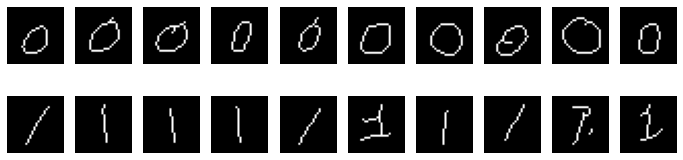

In [9]:
#load image stacks
path_to_img_data='../lab-02-data/part1/'


img_zeros=load_img_seq(os.path.join(path_to_img_data, '0'))
img_ones=load_img_seq(os.path.join(path_to_img_data, '1'))

#skeletonize stacks
skel_zeros=skel_img_stack(img_zeros)
skel_ones=skel_img_stack(img_ones)

#plot skeletons of glyphs
fig, axes = plt.subplots(2, len(skel_ones), figsize=(12, 3))
for ax, im in zip(axes[0], skel_zeros):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
for ax, im in zip(axes[1], skel_ones):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

## Extract features
 two features could be the two inertias along the principal axes od the object,
 but by knowing that some _ones_ are more than just a line but have a given width
 which is comparable with that of the _zeros_ one may not be able to distinguish
 the two elements just by the inertia of the skeletons. So this may not be the
 best features to extract



In [10]:
Lambda_zeros=[]
Lambda_ones=[]

for i in range(len(skel_zeros)):
    # find eigenvalues (inertia) of zeros along principal axis
    Lambda,_=np.linalg.eig(object_covar_mat(skel_zeros[i]))
    Lambda_zeros.append(Lambda)

    #do the same for ones
    Lambda,_=np.linalg.eig(object_covar_mat(skel_ones[i]))
    Lambda_ones.append(Lambda)


## The Results of the Analysis:
 As expected, the classes are not completly separable and overlap as we can see
 in the plot below:


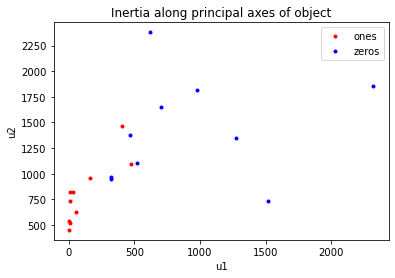

In [11]:
#plot found values
i=0
for [x,y] in Lambda_ones:
    if i==0:
        plt.plot(x,y,'.r',label='ones')
        i+=1
    else:
        plt.plot(x,y,'.r')
i=0
for [x,y] in Lambda_zeros:
    if i==0:
        plt.plot(x,y,'.b',label='zeros')
        i+=1
    else:
        plt.plot(x,y,'.b')

plt.title("Inertia along principal axes of object")
plt.xlabel("u1")
plt.ylabel("u2")
plt.legend()
plt.show()


## Other features:
 other features, not considering the Fourier Descriptors, could be the fact that the
 _ones_ present no loop, wherease _zeros_ do. This however would pose problems
 for the classification of other characters like _6_ and _8_ for example if
 used as only feature. Other features like the distance to a reference char could be a
 good option as well. As a first feature let's define a distance from a reference
 object:


(-0.5, 27.5, 27.5, -0.5)

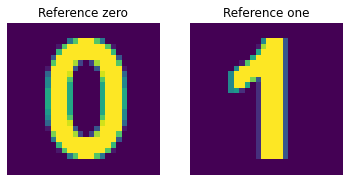

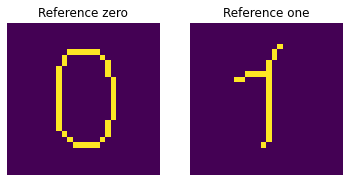

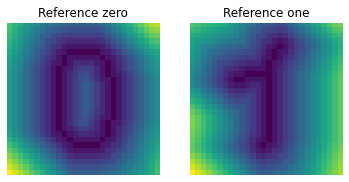

In [13]:
#read and plot reference images
ref_path='../lab-02-data/ref/'
ref_zero=skimage.io.imread(os.path.join(ref_path,'reference0.png'))
ref_one=skimage.io.imread(os.path.join(ref_path,'reference1.png'))
#plot reference images
fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(ref_zero)
ax[1].imshow(ref_one)
ax[0].set_title('Reference zero')
ax[0].axis('off')
ax[1].set_title('Reference one')
ax[1].axis('off')

#skeletonize and plot ref images
ref_zero=skel_and_thld(ref_zero)
ref_one=skel_and_thld(ref_one)
#plot reference skeletons
fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(ref_zero)
ax[1].imshow(ref_one)
ax[0].set_title('Reference zero')
ax[0].axis('off')
ax[1].set_title('Reference one')
ax[1].axis('off')

#create and plot distance map
zero_dist_map=dist_map(ref_zero.astype(int))
one_dist_map=dist_map(ref_one.astype(int))
#plot distamce map
fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(zero_dist_map)
ax[1].imshow(one_dist_map)
ax[0].set_title('Reference zero')
ax[0].axis('off')
ax[1].set_title('Reference one')
ax[1].axis('off')


## Comparison:
 now that the maps have been created it is time to compare the mean distances
 conidered as features here: dx0 = average ditance of object _x_ to the _zeros_ and dx1 is defined
 accordingly for the _ones_

In [14]:
d11=[]
d10=[]

for img in skel_ones:
    #center objects:
    x_com,y_com=com(img)
    img=np.roll(img,(int(x_com),int(y_com)))
    #compute total number of pixels of object
    N=np.sum(img)
    #compute average distance
    d10.append(np.sum(zero_dist_map[img])/N)
    d11.append(np.sum(one_dist_map[img])/N)

d01=[]
d00=[]

for img in skel_zeros:
    #center objects:
    x_com,y_com=com(img)
    img=np.roll(img,(int(x_com),int(y_com)))
    #compute total number of pixels of object
    N=np.sum(img)
    #compute average distance
    d00.append(np.sum(zero_dist_map[img])/N)
    d01.append(np.sum(one_dist_map[img])/N)


## Analysis:
 the result of this feature analysis shows that those features could be used to
 linearly separate the two glyphs one fro the other. Indeed, as one would expect, the _zeros_ show greater
 distance to the reference _one_ and a smaller deistance to the reference _zero_,
 and the same reasoning applies for the _ones_ which show greater proximity to the
 reference _one_ rather than the reference _zero_. The result is shown below:


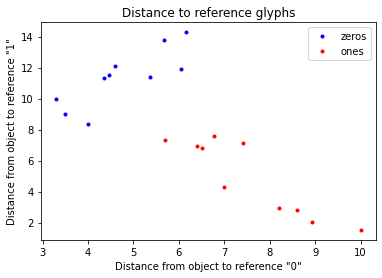

In [15]:
plt.plot(d00,d01,'.b',label='zeros')
plt.plot(d10,d11,'.r',label='ones')
plt.xlabel('Distance from object to reference "0"')
plt.ylabel('Distance from object to reference "1"')
plt.title("Distance to reference glyphs")
plt.legend()
plt.show()